#### Vít Škvára - Samoorganizace a dolování dat/Self-organization and data mining

# Kernel methods for multiple-instance learning problem

In this protocol, we explore the possibily of using kernel methods, namely smallest enclosing hypersphere, for the task of anomaly detection under the multiple-instance learning paradigm.

## Multiple-instance learning (MIL)

In multiple-instance learning (MIL), the problem of supervised binary classification is made more difficult for the learner due to a number of reasons. Firstly, instead of having a set of instances (feature vectors) labeled as negative or positive, a number of _bags_ of instances is received, where the whole bags are labeled as positive or negative. Every bag consists of a (possibly different) number of instances whose individual labels are not known. The common conception is that a bag is labeled negative if all instances in it are negative, but if even a single instance is positive, then the label of the bag is also positive. Secondly, the ratio of negative to positive instances in a bag can be arbitrarily high. In real-world problems however, this presumption can be violated and positive and negative bags may be generated from entirely different sources. 

Our motivation comes from the area of malware detection in computers connected to a network whose activity is supervised. In such a case, the communication of every computer with the outside world (using a HTTP protocol) goes through a common hub. The observer, for a limited time frame, collects all HTTP requests of the computers in the network. From each request, we substract a number of features (e.g. bytes sent and received, request lenght in ms). A collection of such instances for one computer creates a bag. Additionaly, some computers are known to be infected with malware that communicates with the Internet. Their bags are then labeled as positive and together with bags of some uninfected computers compose a training dataset. Presumably, positive bags should contain a number of positive instances - requests created by the malware. 

## Kernel theory basics

Firstly, we will give a brief introduction to kernel methods and the smallest hypersphere algorithm that will be used to detect outliers or anomalies. A kernel is a mapping
\begin{equation}
    \kappa(x,y) = \langle \phi(x), \phi(y) \rangle
\end{equation}
that encodes data $x,y \in \mathcal{X}$ to feature space $\mathcal{F}$ using a scalar product of an embedding map 
\begin{equation}
    \phi:\mathcal{X} \rightarrow \mathcal{F}.
\end{equation}

The trick of kernel methods is that for a training dataset $X= \lbrace x_1, x_2, \dots, x_m \rbrace$, they are able to use standar linear machine learning techniques on the richer feature space $\mathcal{F}$ without directly computing the potentially computationally demanding mapping $\phi(x_i), i = 1, 2, \dots, m$. Instead, it is sufficient to obtain the kernel matrix $G$, which satistfies 
\begin{equation}
    G_{ij} = \kappa(x_i,x_j) = \langle \phi(x_i), \phi(x_j) \rangle.
\end{equation}
This matrix is symmetric and enables us to use a large number of classical algorithms in the feature space.

The quadratic kernel is one of the simplest. It is defined as 
\begin{equation}
    \kappa(x,y) = \langle x, y \rangle^2
\end{equation}
and its corresponding feature map for $\mathcal{X} = \mathbb{R}^2$ is 
\begin{equation}
    \phi(x) = (x_1^2, x_2^2, \sqrt{2}x_1x_2) 
\end{equation}
embeds the original samples to feature space $\mathcal{F} = \mathbb{R}^3$.



## The smallest enclosing hypersphere algorithm

The idea is to find a smallest enclosing hypersphere of the training dataset $X$ in feature space $\mathcal{F}$ that is defined by center $c \in \mathcal{F}$ and radius $r\in \mathbb{R}$. This translates to a nonlinear optimization problem for an unknown weight vector $\alpha \in \mathbb{R}^n$ defined as
\begin{equation}
    \max_{\alpha} W(\alpha) = \alpha^T \text{diag}(G) - \alpha^T G \alpha
\end{equation}
\begin{equation}
    \text{s.t.} \sum_{i=1}^n \alpha_i = 1, \alpha_i \geq 0, i = 1, \dots, n
\end{equation}
where $\text{diag}(G)$ is a vector containing the diagonal elements of $G$.

Let $\alpha^*$ denote the found optimal solution. Then the following holds
\begin{equation}
    r^* = \sqrt{W(\alpha^{*})}
\end{equation}
\begin{equation}
    c^* = \sum_{i=1}^n \alpha_i^* \phi(x_i)
\end{equation}
where $r^*, c^*$ are the radius and center of the smallest sphere that contains all the training data.

For a new sample $x$, the testing function that determines whether the point lies inside or outside the sphere has the following  form
\begin{equation}
    f(x) = \kappa(x,x) - 2 \sum_{i=1}^n \alpha_i^* \kappa(x_i,x) + \alpha^{*T} G \alpha^* - r^{*2}.
\end{equation}
If $f(x) \geq 0$, then the sample lies inside the sphere, otherwise it is outside.

Note that for the computation of the testing function, the exact form  of the feature map $\phi(x)$ is not needed as it is not required here.


## Experiment 1

First we implement the smallest enclosing sphere algorithm and test it on a simple benchmark problem.

In [4]:
# here, the required libraries are loaded
using Convex, SCS # for optimization
using ClobberingReload # for deprecation warnings supression
using PyPlot # for plots

We generate a training and a testing dataset in $\mathbb{R}^2$.

In [22]:
m = 2 # problem dimension
c_data = [1,4] # the data will be offset by this
n_train = 20 # no training samples
X_train = randn(2,n_train) .+ c_data

n_test = 20
X_test = randn(2,n_test) .+ c_data
A = randn(2, n_test)*10 .+ c_data 
X_test = cat(2, X_test, A)

2×40 Array{Float64,2}:
 -0.163088  -0.116794  -0.174207  1.83562  …   2.41714  12.2685   16.0055 
  4.25024    7.00803    3.53072   5.35841     23.7956   -4.80504   8.23379

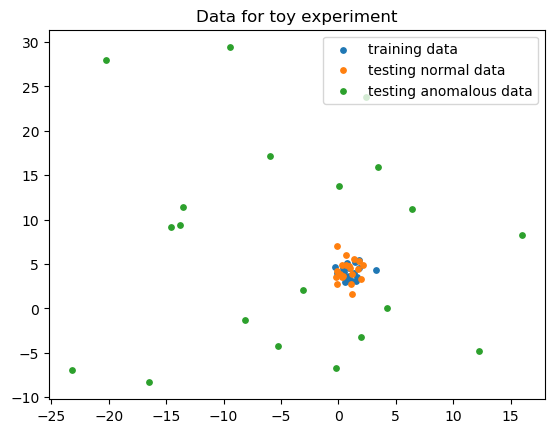

PyObject Text(0.5,1,'Data for toy experiment')

In [32]:
f = figure()
ss = 15
scatter(X_train[1,:], X_train[2,:], s=ss, label = "training data")
scatter(X_test[1,1:n_test], X_test[2,1:n_test], s = ss, 
    label = "testing normal data")
scatter(X_test[1,n_test+1:end], X_test[2,n_test+1:end], s = ss,
    label = "testing anomalous data")
legend()
title("Data for toy experiment")

We will use the quadratic kernel as the generating function has quite a simple form. We will use the form with offset
\begin{equation}
    \kappa(x,y) = (\langle x, y \rangle + c)^2
\end{equation}
which has a feature map
\begin{equation}
    \varphi(x) = \left( x_1^2, \ldots, x_m^2, \sqrt{2} x_1 x_{2}, \ldots, \sqrt{2} x_1 x_m, \sqrt{2} x_2 x_3, \ldots, \sqrt{2} x_2 x_m, \ldots, \sqrt{2} x_{m-1} x_{m}, \sqrt{2c} x_1, \ldots, \sqrt{2c} x_m, c \right)
\end{equation}
We know that the resulting feature space $\mathcal{F}$ has dimension ${m+2\choose 2} = 6$ for $m=2$. 

Below, the feature map for a quadratic kernel and a sample space of arbitrary dimension is implemented.

In [57]:
"""
    quadmap(x, c = 0.0)

Is the feature map for quadratic kernel.
"""
function quadmap(x, c = 0.0)
    m = length(x)
    nq = binomial(m+2,2)
    
    # decrease the resulting dimension if c is zero
    if c == 0
        nq -= (m+1)
    end
    
    # create the resulting array
    res = zeros(nq)
    
    # first the solo quadratic coefficients
    res[1:m] = x.^2
    
    # now the cross-quadratics
    k = 1+m
    for i in 1:m
        for j in 1:(m-i) 
           res[k] = sqrt(2)*x[i]*x[j]
            k += 1
        end
    end
    
    if c != 0
        # now the linear elements
        for i in 1:m
           res[k] = sqrt(2*c)*x[i]
            k += 1
        end

        # now the final constant
        res[end] = c
    end
    
    return res
end

quadmap

Below here, the type for quadratic kernel is implemented along with a constructor. The constructor is called with data $X$ and offset $c$. It computes and stores the kernel matrix and initializes the feature map. Also, an object of type `quadkernel` can be called directly as `quadkernel(x,y)` or `quadkernel(x)` to obtain the value for vectors `x,y`.

In [69]:
# abstract kernel type
abstract type kernel
end

# quadratic kernel type
struct quadkernel <: kernel
    km # kernel matrix
    ϕ # feature map
    c
end

# constructor
quadkernel(X, c=0) = quadkernel((X'*X .+ c).^2, x -> quadmap(x,c), c)

# overloaded for direct calling
(qk::quadkernel)(x,y) = (x'*y + qk.c).^(2)
(qk::quadkernel)(x) = qk(x,x)

Now we initialize a new object of type `quadkernel` with the training data. We set $c=0$. Also, we visualize the kernel matrix after initialization.

In [71]:
qk = quadkernel(X_train)
qk.km

20×20 Array{Float64,2}:
 549.599  200.967   279.326   283.748  …  640.539  345.606  255.463   457.876
 200.967   79.2357   99.1733  112.366     210.02   123.378   93.6861  187.637
 279.326   99.1733  143.55    139.777     338.842  177.249  129.691   222.429
 283.748  112.366   139.777   159.388     294.559  173.95   132.3     266.673
 554.885  222.452   271.988   315.763     565.26   338.798  258.845   531.151
 676.031  257.658   338.124   364.677  …  742.937  419.598  314.732   599.808
 365.462  148.265   178.272   210.598     365.453  222.264  170.563   356.081
 307.216  131.877   146.364   187.906     280.165  183.295  143.708   325.383
 420.236  156.627   212.02    221.394     476.862  262.685  195.476   360.441
 391.631  159.732   190.62    226.954     388.339  237.756  182.816   384.619
 412.23   180.345   194.803   257.232  …  363.896  244.333  192.982   448.91 
 238.585   89.4576  120.094   126.493     268.443  148.856  111.005   206.506
 495.567  194.42    245.04    275.633   

In [51]:
quadmap(X_train[:,1], 1)

6-element Array{Float64,1}:
  3.23149
 20.212  
  4.57001
  2.54224
  6.35799
  1.0    

In [52]:
quadmap(X_train[:,1])

3-element Array{Float64,1}:
  3.23149
 20.212  
  4.57001

In [49]:
X_train[:,1]

2-element Array{Float64,1}:
 1.79763
 4.49578

In [2]:
# this contains some helper functions for MIL manipulation
include("/home/vit/Dropbox/vyzkum/cisco/kod/lib/julia/VBMatrixFactorization/examples/mil_util.jl")

plot_statistics

In [6]:
struct polykernel <: kernel
    p # polynomial order
    c # offset
    x # the data
    km # kernel matrix
    ϕ # generating function
end

# abbreviated constructor
polykernel(X::AbstractArray, p::Int, c = 0.0) = 
     polykernel(p, ones(size(X,1))*c, X, (X*X').^p, nothing)

# overloaded for direct calling
(pk::polykernel)(x) = (x'*x + c)^(pk.p)

In [5]:
X = rand(3,6)
krnl = polykernel(X,2)

polykernel(2, [0.0238552 0.29988 … 0.855878 0.301596; 0.851979 0.939919 … 0.929722 0.242266; 0.552347 0.137169 … 0.976116 0.76581], [2.1257 1.50628 2.70062; 1.50628 6.44282 3.05084; 2.70062 3.05084 5.59467], nothing)

In [9]:
# kernelized smallest hypersphere for anomaly detection
mutable struct kernel_sh
    k::kernel
    α
    r
    D
    c
    opt
end

# constructor
kernel_sh(k::kernel) = kernel_sh(k, Array{Float64,1}([]), NaN, NaN, NaN, false)

kernel_sh

In [10]:
ksh = kernel_sh(krnl)

kernel_sh(polykernel(2, [0.0238552 0.29988 … 0.855878 0.301596; 0.851979 0.939919 … 0.929722 0.242266; 0.552347 0.137169 … 0.976116 0.76581], [2.1257 1.50628 2.70062; 1.50628 6.44282 3.05084; 2.70062 3.05084 5.59467], nothing), Float64[], NaN, NaN, NaN, false)

In [11]:
W(α,gm) = diag(gm)'*α - sum(gm.*(α*α'))
W(ksh::kernel_sh) = W(ksh.α, ksh.k.gm)

function find_sphere!(ksh::kernel_sh)
    # this is the optimization part using Convex and SCS packages
    # setup the variables, objective and constraints
    n = size(ksh.k.gm,1)
    α = Variable(n, Positive())
    dgm = diag(ksh.k.gm)'
    dg = ksh.k.gm
    objective = dgm*α - quadform(α, dg)
    constraints = [sum(α) == 1.0]
    problem = maximize(objective, constraints) 
    # solve
    no_warnings() do
        solve!(problem)
    end
    # if succesfully solved, extract and round the optimal solution
    if problem.status == :Optimal
        ksh.α = round.(problem.solution.primal[1:n], 3)
        ksh.opt = true
    else
        error("solution not found!")
    end
    
    # compute the radius
    ksh.r = sqrt(W(ksh))
    # compute D for the anomaly score function
    ksh.D = ksh.α'*ksh.k.gm*ksh.α - ksh.r^2
    # compute the center - but we don't really need this
    # also, it may not be possible for some kernels
    if !(ksh.k.ϕ == nothing)
        ksh.c = ksh.α'*ksh.k.ϕ.(ksh.k.x)
    end
end

function anomaly_score(ksh::kernel_sh, x)
    return ksh.k
end

LoadError: [91msyntax: incomplete: "function" at In[11]:37 requires end[39m

In [23]:
find_sphere!(ksh)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 24
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 6, constraints m = 13
Cones:	primal zero / dual free vars: 2
	linear vars: 4
	soc vars: 7, soc blks: 2
Setup time: 4.29e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  2.28e-05 
   100| 1.34e-03  2.28e-02  1.92e-02 -8.82e-01 -9.36e-01  7.39e-17  6.60e-05 
   200| 4.64e-05  6.51e-04  5.01e-04 -8.93e-01 -8.95e-01  7.35e-17  1.07e-04 
   240| 1.49e-05  3.91e-05  4.08e-

In [26]:
ksh.D

0.5168458726337386